In [19]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable

from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [20]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab\ Notebooks/Torch/chap07

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Torch/chap07


In [21]:
data = pd.read_csv('../chap07/data/SBUX.csv')

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data['Volume'] = data['Volume'].astype(float)

In [22]:
X = data.iloc[:, :-1]
y = data.iloc[:, 5:6]
# print(X)
# print(y)

In [23]:
ms = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:200, :]
X_test = X_ss[200:, :]

y_train = y_ms[:200, :]
y_test = y_ms[200:, :]

print(f"Training Shape: {X_train.shape} {y_train.shape}")
print(f"Testing Shape: {X_test.shape} {y_test.shape}")

Training Shape: (200, 5) (200, 1)
Testing Shape: (53, 5) (53, 1)


In [24]:
# Variable로 감싸진 텐서는 .backward()가 호출될 때 자동으로 기울기가 계산
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

print("Training Shape", X_train_tensors_f.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_f.shape, y_test_tensors.shape) 

Training Shape torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape torch.Size([53, 1, 5]) torch.Size([53, 1])


In [25]:
class GRU(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(GRU, self).__init__()
        self.num_classes = num_classes 
        self.num_layers = num_layers 
        self.input_size = input_size 
        self.hidden_size = hidden_size 
        self.seq_length = seq_length 

        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) 
        self.fc_1 =  nn.Linear(hidden_size, 128) 
        self.fc = nn.Linear(128, num_classes) 
        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) 
        output, (hn) = self.gru(x, (h_0)) 
        hn = hn.view(-1, self.hidden_size) 
        out = self.relu(hn)
        out = self.fc_1(out) 
        out = self.relu(out) 
        out = self.fc(out) 
        return out

In [26]:
num_epochs = 1000 
learning_rate = 0.0001 

input_size = 5 
hidden_size = 2 
num_layers = 1 

num_classes = 1 
model = GRU(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1]) 

criterion = torch.nn.MSELoss()    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

In [27]:
for epoch in range(num_epochs):
    outputs = model.forward(X_train_tensors_f) 
    optimizer.zero_grad()  
    loss = criterion(outputs, y_train_tensors)
    loss.backward() 
 
    optimizer.step() 
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.11656
Epoch: 100, loss: 0.05111
Epoch: 200, loss: 0.03986
Epoch: 300, loss: 0.03581
Epoch: 400, loss: 0.03368
Epoch: 500, loss: 0.03279
Epoch: 600, loss: 0.03251
Epoch: 700, loss: 0.03246
Epoch: 800, loss: 0.03244
Epoch: 900, loss: 0.03243


In [28]:
df_x_ss = ss.transform(data.iloc[:, :-1]) 
df_y_ms = ms.transform(data.iloc[:, -1:]) 

df_x_ss = Variable(torch.Tensor(df_x_ss)) 
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1])) 

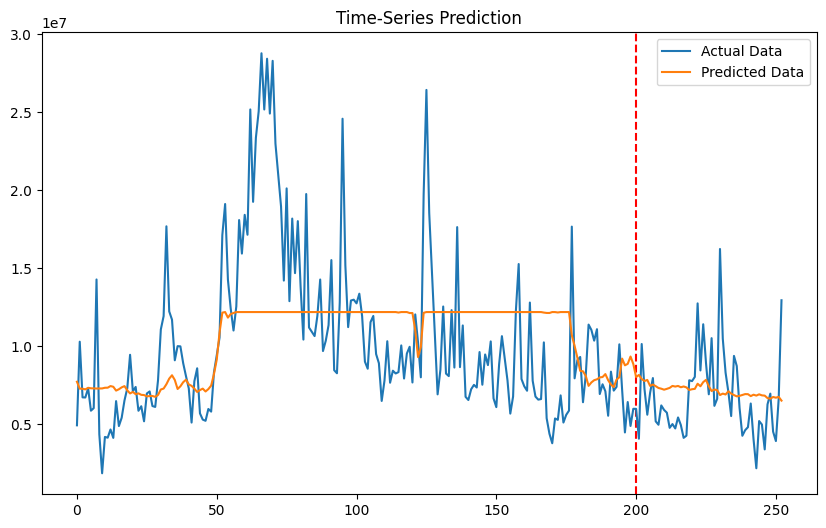

In [29]:
train_predict = model(df_x_ss)
predicted = train_predict.data.numpy() 
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted) 
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10,6)) 
plt.axvline(x=200, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data') 
plt.plot(predicted, label='Predicted Data') 
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 